<a href="https://colab.research.google.com/github/szsavery/DSPS_SSavery/blob/main/Labs/DSPS2023_autoencoders_8dec23_Savery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from copy import deepcopy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.signal import convolve2d

from tensorflow import keras
from keras.datasets import mnist
from keras import layers

!pip install icecream
from icecream import ic

rng = np.random.RandomState(1415)

# Load MNIST data

In [2]:
# Load the data and split it between train and test sets
(Xtrn, Ytrn), (Xtst, Ytst) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Visualize dataset

In [3]:
Xtrn.shape, Xtst.shape, Ytrn.shape, Ytst.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [4]:
np.unique(Ytrn)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [5]:
def plot_images(images, labels, nrows = 5, ncols = 5, vmin = 0, vmax = 255):
  fig, axes = plt.subplots(nrows, ncols, sharex = True, sharey = True, figsize = (8,8))

  for i in range(nrows*ncols):
    ax = axes.flatten()[i]
    image = images[i]
    label = labels[i]

    ax.set_title(label)
    ax.imshow(image, vmin = vmin, vmax = vmax, cmap = 'Greys')
    ax.set_aspect('equal')
    ax.axis('off')

  fig.tight_layout()
  fig.show()

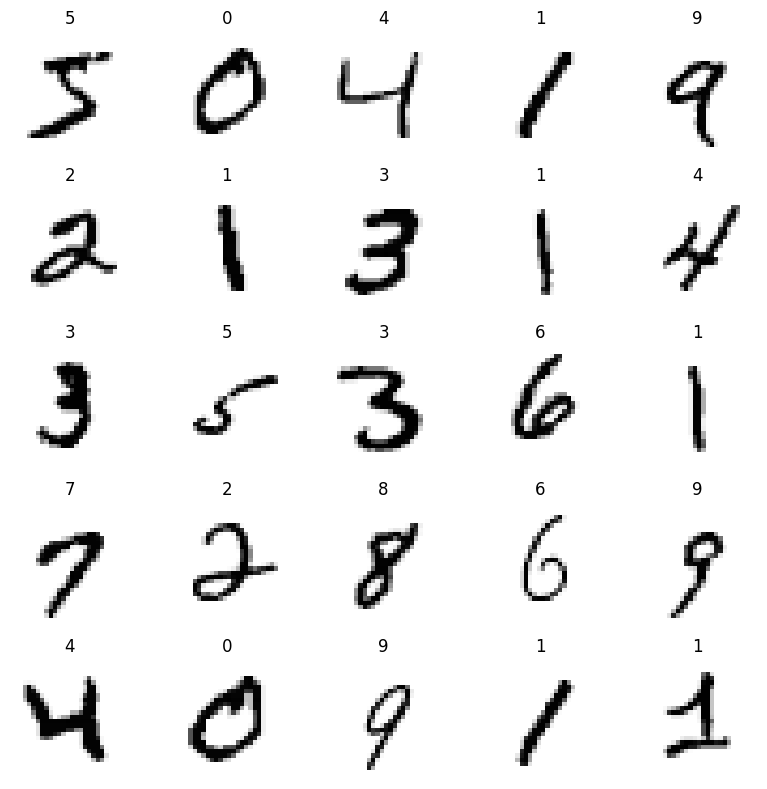

In [6]:
plot_images(Xtrn, Ytrn)

# Normalize the images

In [7]:
def normalize_255(array):
  normed_array = array / 255
  return normed_array


XtrnN = normalize_255(Xtrn)
XtstN = normalize_255(Xtst)

In [8]:
XtrnN.max(), XtstN.max()

(1.0, 1.0)

# Reshape the arrays for Keras

In [9]:
def reshape_for_keras(array):
  reshaped_array = array[..., None]
  return reshaped_array

In [10]:
XtrnNR = reshape_for_keras(XtrnN)
XtstNR = reshape_for_keras(XtstN)

In [11]:
XtrnNR.shape

(60000, 28, 28, 1)

# But wait we don't need the image labels...

### The training set will be the images at half resolution, and the model will try to up-sample the images to the original resolution... `Xtrn` should be the same 60,000 images at half resolution, but `Ytrn` should be those same images at the original resolution. We will do the same operations for the testing set.

# Construct dataset for superresolution, not image classification

In [12]:
def superresolution(X):
  Xnew = deepcopy(X)[:, ::2, ::2,:]
  Ynew = deepcopy(X)

  return Xnew, Ynew


XtrnSR, YtrnSR = superresolution(XtrnNR)
XtstSR, YtstSR = superresolution(XtstNR)

In [13]:
XtrnSR.shape, YtrnSR.shape

((60000, 14, 14, 1), (60000, 28, 28, 1))

# Visualize the new dataset

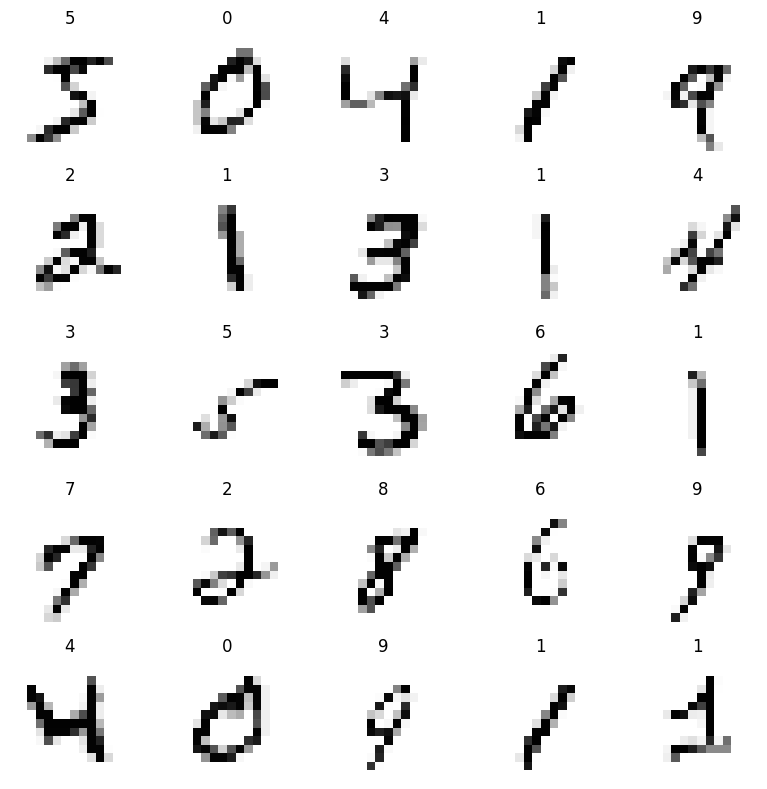

In [14]:
plot_images(XtrnSR[:,:,:,0], Ytrn, vmax = 1)

# Build the CNN autoencoder

In [15]:
def build_cnn_autoencoder(input_shape):

  inputs = layers.Input(shape = input_shape)
  #The encoder
  x = layers.Conv2D(16, kernel_size= (3,3), padding = 'same', activation = 'relu')(inputs)
  x = layers.Conv2D(8, kernel_size= (3,3), padding = 'same', activation = 'relu')(x)
  x = layers.Conv2D(4, kernel_size= (3,3), padding = 'same', activation = 'relu')(x)
  x = layers.MaxPooling2D(pool_size= (2,2))(x)

  shape = x.shape
  num_neurons = shape[1]*shape[2]*shape[3]

  #latent shape
  x = layers.Flatten()(x)
  LS = layers.Dense(16,activation='relu')(x)
  x = layers.Dense(num_neurons, activation='relu')(LS)
  x = layers.Reshape(shape[1:])(x)

  #The decoder
  x = layers.Conv2DTranspose(4, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.Conv2DTranspose(8, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.UpSampling2D(size = (2,2))(x)

  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'relu')(x)
  x = layers.UpSampling2D(size = (2,2))(x)

  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'sigmoid')(x)
  x = layers.Conv2DTranspose(16, kernel_size= (3,3), padding = 'same', activation= 'sigmoid')(x)
  outputs = layers.Conv2DTranspose(1, kernel_size= (3,3), padding = 'same', activation= 'sigmoid')(x)

  model = keras.Model(inputs, outputs)

  encoder = keras.Model(inputs, LS)
  decoder = keras.Model(LS, outputs)

  return model, encoder, decoder

input_shape = XtrnSR.shape[1:]
model, encoder, decoder = build_cnn_autoencoder(input_shape)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 4)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                             

# Train the model (use a GPU)

In [16]:
model.compile(loss = 'mse', optimizer= 'adam')
history = model.fit(XtrnSR, YtrnSR, batch_size = 256, epochs = 15, validation_split= 0.1)

Epoch 1/15
211/211 [==============================] - 19s 18ms/step - loss: 0.1053 - val_loss: 0.0709
Epoch 2/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0490 - val_loss: 0.0368
Epoch 3/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0305 - val_loss: 0.0265
Epoch 4/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0249 - val_loss: 0.0231
Epoch 5/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0221 - val_loss: 0.0208
Epoch 6/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0203 - val_loss: 0.0195
Epoch 7/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0191 - val_loss: 0.0185
Epoch 8/15
211/211 [==============================] - 3s 13ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 9/15
211/211 [==============================] - 3s 15ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 10/15
211/211 [==============================] - 3s 14ms/step - loss: 0.0170 - val_l

# Visualize the predictions

In [17]:
PtstSR = model.predict(XtstSR)
PtstSR.shape

313/313 [==============================] - 1s 3ms/step


(10000, 28, 28, 1)

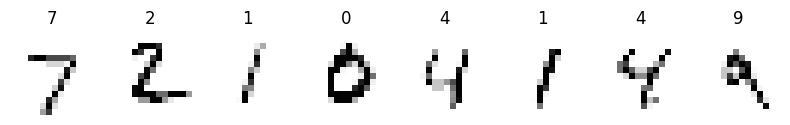

In [18]:
plot_images(XtstSR[:,:,:,0], Ytst, nrows = 1, ncols = 8, vmax = 1)

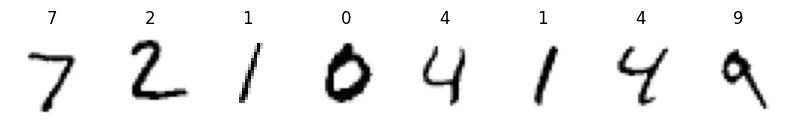

In [19]:
plot_images(YtstSR[:,:,:,0], Ytst, nrows = 1, ncols = 8, vmax = 1)

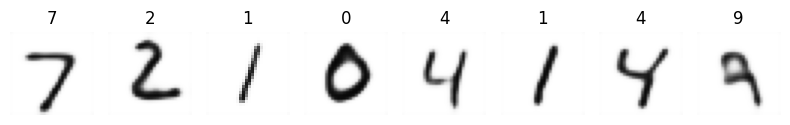

In [20]:
plot_images(PtstSR[:,:,:,0], Ytst, nrows = 1, ncols = 8, vmax = 1)

# Visualize loss curve

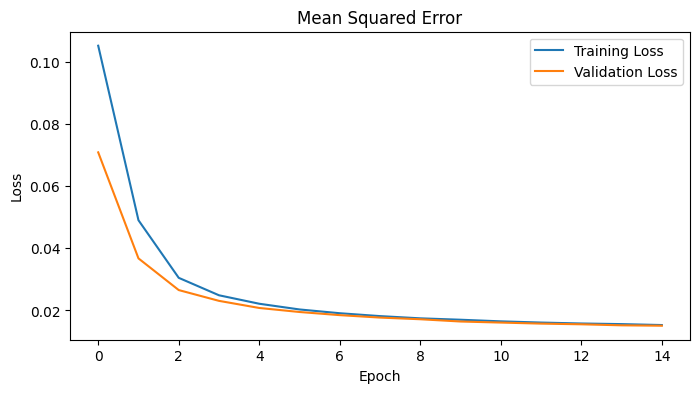

In [21]:
#Got this code from the shared solutions code
def plot_curves(history):
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(8, 4))

    ax.set_title("Mean Squared Error")
    ax.plot(history["loss"], label="Training Loss")
    ax.plot(history["val_loss"], label="Validation Loss")
    ax.legend(loc="upper right")
    ax.set_ylabel("Loss")

    ax.set_xlabel("Epoch")

plot_curves(history.history)

# Visualize the early layers

In [22]:
model.layers[1].get_weights()[0].shape

(3, 3, 1, 16)

In [23]:
#Got this code from the shared solution code
def plot_kernels_on_image(image, layer, plot_kernels=False):
    kernels = layer.get_weights()[0][:, :, 0, :]
    num_kernels = kernels.shape[-1]

    fig, axes = plt.subplots(1, num_kernels, sharex=True, sharey=True, figsize=(16, 6))

    for i in range(num_kernels):
        kernel = kernels[:, :, i]
        ax = axes.flatten()[i]

        if plot_kernels:
            ax.imshow(kernel, cmap="Greys")

        else:
            convolved_image = convolve2d(image, kernel, mode="same")
            ax.imshow(convolved_image, cmap="Greys")

        ax.set_aspect("equal")
        ax.axis("off")

    fig.tight_layout()
    fig.show()

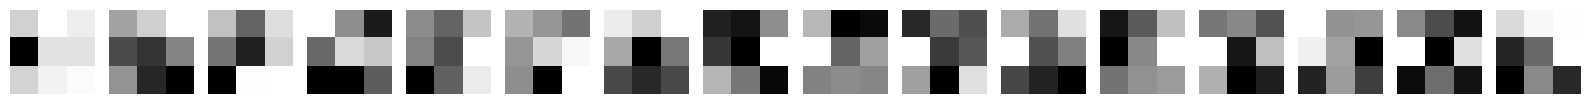

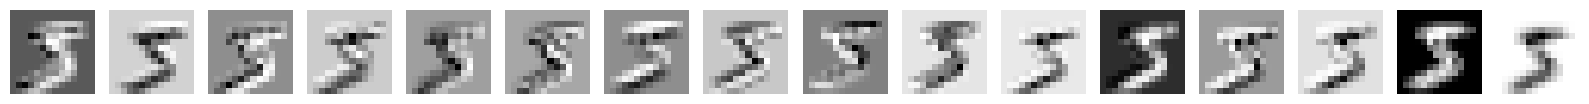

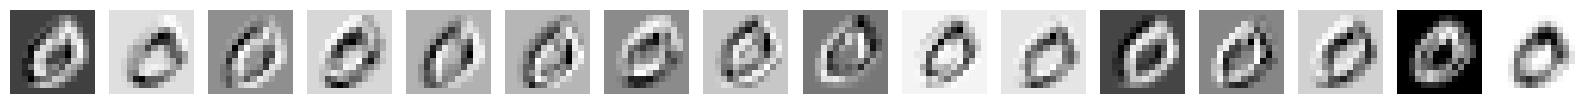

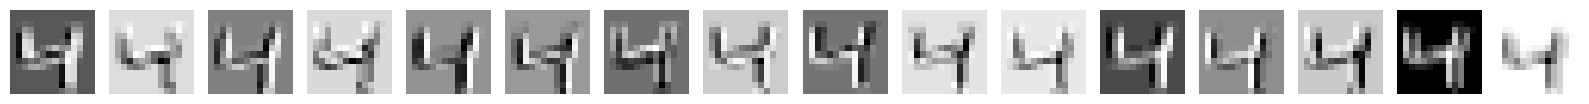

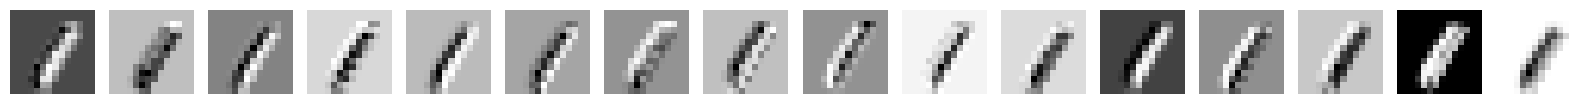

In [24]:
plot_kernels_on_image(XtrnSR[0, :, :, 0], model.layers[1], plot_kernels=True)
plot_kernels_on_image(XtrnSR[0, :, :, 0], model.layers[1])
plot_kernels_on_image(XtrnSR[1, :, :, 0], model.layers[1])
plot_kernels_on_image(XtrnSR[2, :, :, 0], model.layers[1])
plot_kernels_on_image(XtrnSR[3, :, :, 0], model.layers[1])

# Visualize the latent space with the encoder and decoder on their own

In [25]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 4)         292       
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 4)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 196)               0         
                                                           

In [26]:
LS = encoder.predict(XtstSR)
ic(LS.shape)

LS_images = LS.reshape((10_000,4,4))

313/313 [==============================] - 1s 3ms/step


ic| LS.shape: (10000, 16)


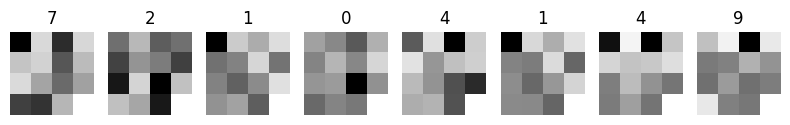

In [30]:
#From shared solutions
plot_images(LS_images, Ytst, nrows=1, ncols=8, vmin=None, vmax=None)

# Find the average latent space representation for each digit

# Decode latent space representations with the decoder

In [31]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 196)               3332      
                                                                 
 reshape (Reshape)           (None, 7, 7, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 4)           148       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 7, 7, 8)           296       
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 7, 7, 16)          1168

In [32]:
output = decoder.predict(LS)
output.shape

313/313 [==============================] - 1s 2ms/step


(10000, 28, 28, 1)

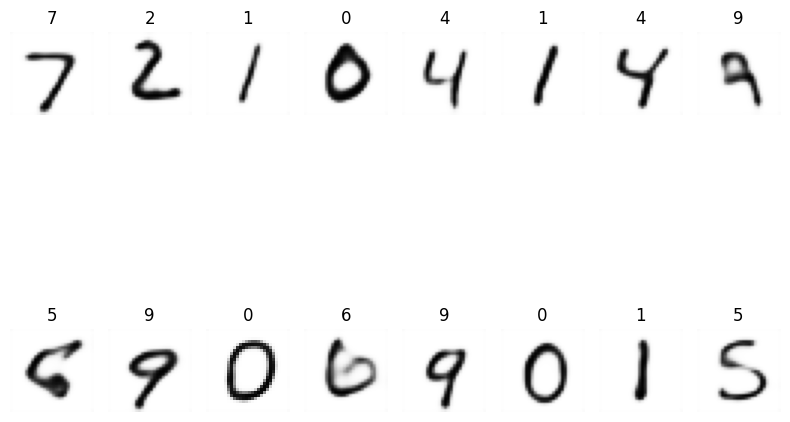

In [33]:
#Code from the shared solutions
plot_images(output[..., 0], Ytst, nrows=2, ncols=8, vmin=None, vmax=None)

# What if we input something in the latent space by hand and then decode it?

313/313 [==============================] - 1s 3ms/step


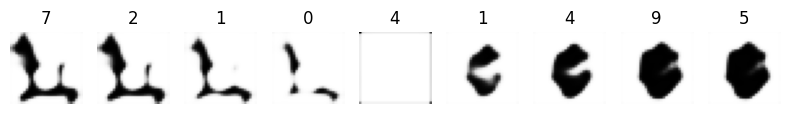

In [34]:
#Code from the shared solutions
LS_manual = np.zeros_like(LS)

# Try one image set to -100
LS_manual[0] = -100
LS_manual[1] = -50
LS_manual[2] = -10
LS_manual[3] = -5
LS_manual[4] = 0
LS_manual[5] = 5
LS_manual[6] = 10
LS_manual[7] = 50
LS_manual[8] = 100

output = decoder.predict(LS_manual)
plot_images(output[..., 0], Ytst, nrows=1, ncols=9, vmin=None, vmax=None)

313/313 [==============================] - 1s 3ms/step


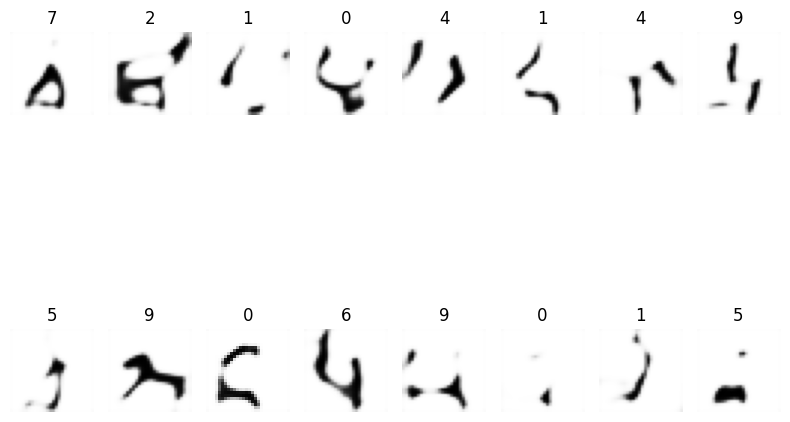

In [35]:
#From shared solutions code
# Try all random noise between -10 and 10:
from scipy import stats

LS_manual = stats.uniform.rvs(loc=-10, scale=20, size=LS.shape)
output = decoder.predict(LS_manual)
plot_images(output[..., 0], Ytst, nrows=2, ncols=8, vmin=None, vmax=None)